[nltk_data] Downloading package stopwords to /Users/alial-
[nltk_data]     taweel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/alial-
[nltk_data]     taweel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


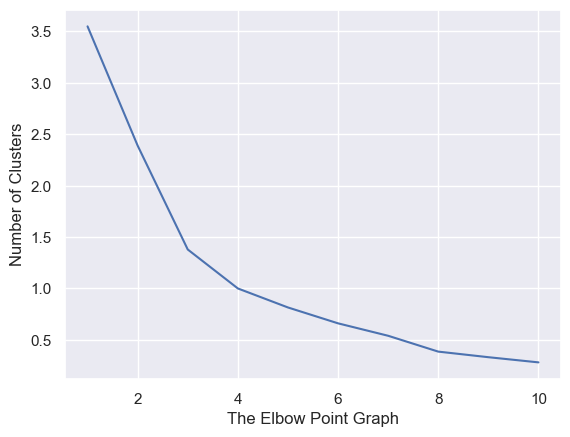

Text(0.5, 1.0, 'Silhouette Score of each Algorithm')

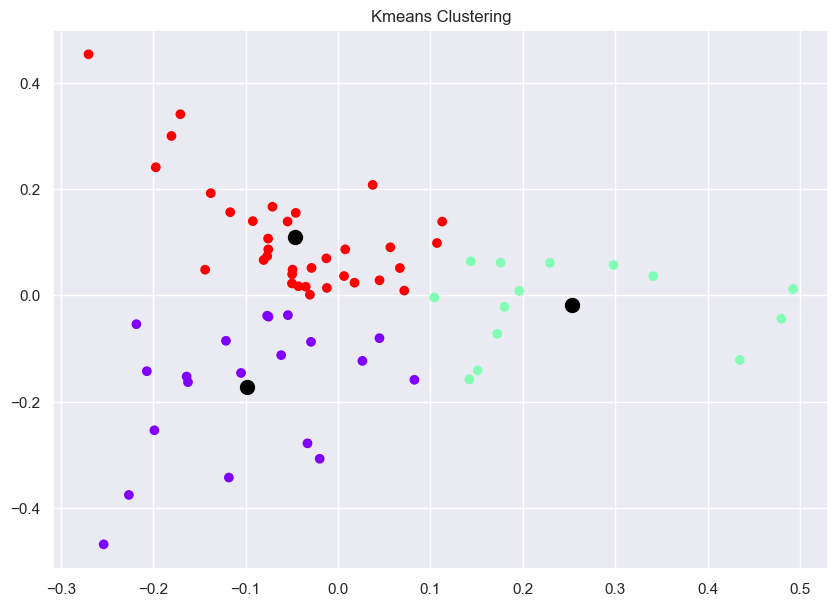

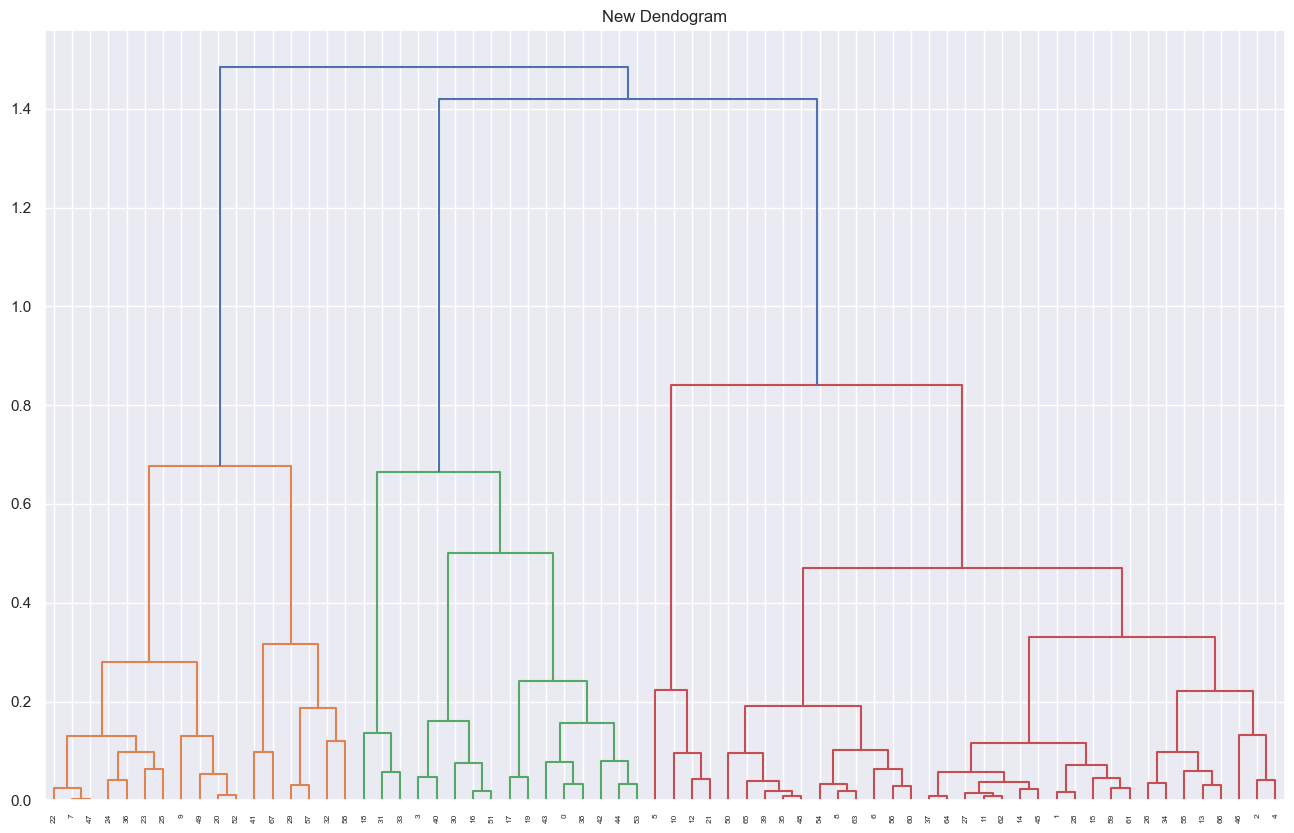

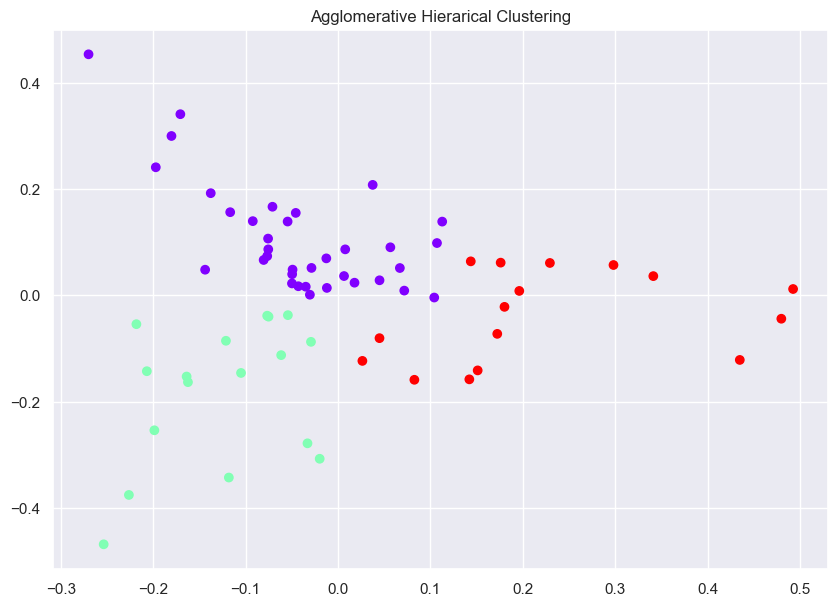

<Figure size 1200x800 with 0 Axes>

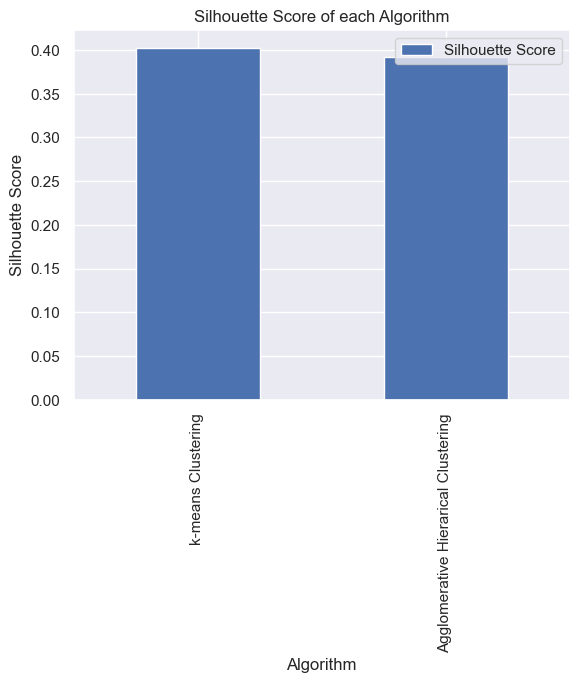

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from sklearn_extra.cluster import KMedoids
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import pickle

news_data = pd.read_table("../data/news_data.tsv", delimiter="\t")
news_data.drop(columns=['2635.json', 'abortion', 'dwayne-bohac', 'State representative', 'Texas', 'republican', '0', '1', '0.1', '0.2', '0.3', 'a mailer'], inplace=True)
news_data.columns=["label", "news_text"]

news_data.isnull().sum()

each_label_count = news_data["label"].value_counts()
news_data_half_true_only = news_data[news_data["label"] == "half-true"].iloc[0:34]
news_data_false_only = news_data[news_data["label"] == "false-only"].iloc[0:34]
news_data_mostly_true_only = news_data[news_data["label"] == "mostly-true-only"].iloc[0:34]
news_data_true_only = news_data[news_data["label"] == "true-only"].iloc[0:34]
news_data_barely_true_only = news_data[news_data["label"] == "barely-true-only"].iloc[0:34]
news_data_pants_fire_only = news_data[news_data["label"] == "pants-fire"].iloc[0:34]

new_news_dataset = pd.concat([news_data_half_true_only, news_data_false_only, news_data_mostly_true_only, news_data_true_only, news_data_barely_true_only, news_data_pants_fire_only], axis=0)

nltk.download("stopwords")
nltk.download("punkt")

ps = PorterStemmer()

def preprocess_text(text):

    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    tokens = [ps.stem(word) for word in tokens]

    return " ".join(tokens)

new_news_dataset['preprocessed_news_text'] = new_news_dataset['news_text'].apply(preprocess_text)

new_news_dataset.drop(columns=["news_text"], inplace=True)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(new_news_dataset["preprocessed_news_text"]).toarray()

pca = PCA(n_components=2, random_state=42)
X = pca.fit_transform(X)
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

sns.set()

plt.plot(range(1,11),wcss)
plt.xlabel("The Elbow Point Graph")
plt.ylabel("Number of Clusters")
plt.show()

kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42)
kmeans.fit_predict(X)
kmeans_labels = kmeans.labels_
kmeans_labels
#print(f"this KMeans labels : {kmeans_labels}")

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='centroid')
plt.title('Kmeans Clustering')

silhouette_score_kmeans = silhouette_score(X, kmeans_labels)
silhouette_score_kmeans

plt.figure(figsize=(16,10))
plt.title("New Dendogram")
dend = shc.dendrogram(shc.linkage(X,method="ward"))
cluster_hieraracial = AgglomerativeClustering(n_clusters=3, linkage="ward")
cluster_hieraracial.fit_predict(X)
hiearachy_labels = cluster_hieraracial.labels_

plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1], c=hiearachy_labels, cmap="rainbow")
plt.title("Agglomerative Hierarical Clustering")
silhouette_score_hierarchy = silhouette_score(X, hiearachy_labels) 
silhouette_score_hierarchy

silhoutte_score_df = pd.DataFrame({
    'Algorithm': ['k-means Clustering',  'Agglomerative Hierarical Clustering'],
    'Silhouette Score': [silhouette_score_kmeans, silhouette_score_hierarchy]
})

plt.figure(figsize=(12, 8))

silhoutte_score_df.plot(kind='bar', x='Algorithm')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score of each Algorithm')


[nltk_data] Downloading package stopwords to /Users/alial-
[nltk_data]     taweel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/alial-
[nltk_data]     taweel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


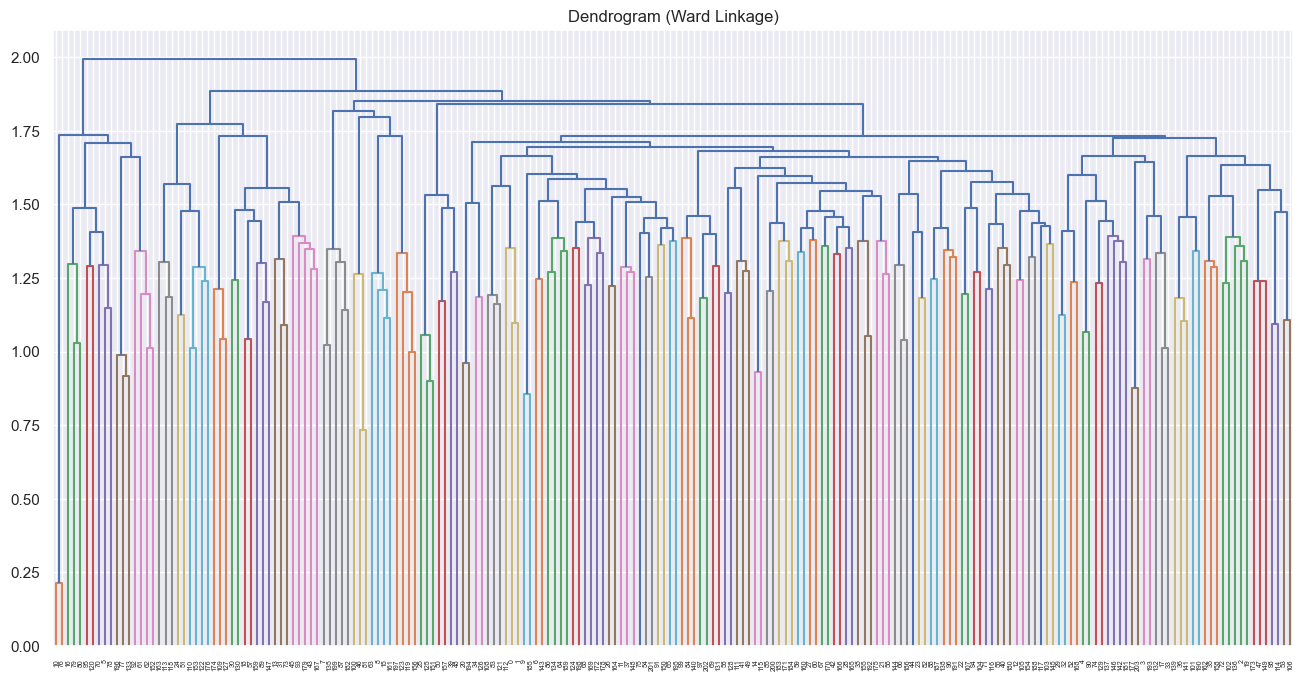

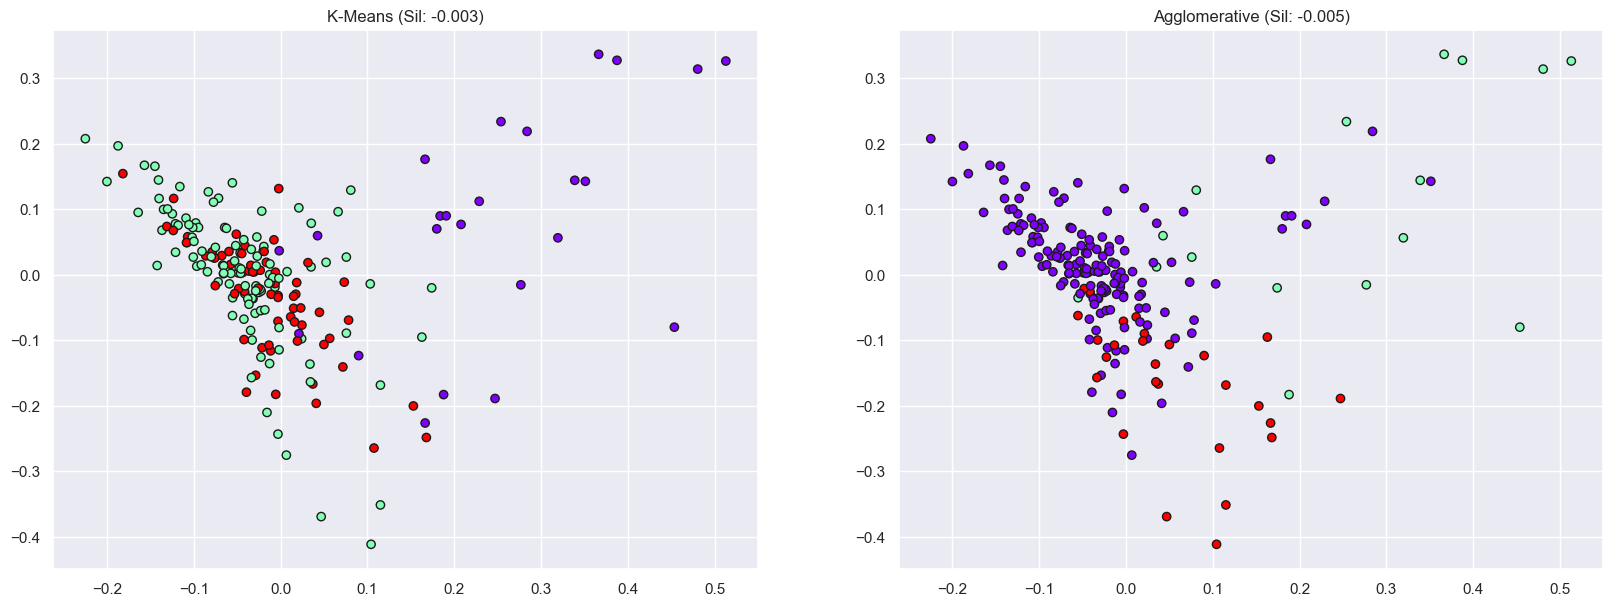

K-Means Silhouette Score: -0.0030
Hierarchical Silhouette Score: -0.0050


In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc

# 1. Data Loading & Cleaning
news_data = pd.read_table("../data/news_data.tsv", delimiter="\t", header=None)
# Based on your previous code, it seems you are dropping metadata columns
# Ensure your column count matches your drop list
news_data = news_data[[1, 2]] # Keeping 'label' and 'text' columns by index
news_data.columns = ["label", "news_text"]

# 2. Balancing the Dataset
# Taking 34 samples per category to ensure a balanced cluster analysis
categories = ["half-true", "false", "mostly-true", "true", "barely-true", "pants-fire"]
balanced_list = []
for cat in categories:
    balanced_list.append(news_data[news_data["label"] == cat].iloc[0:34])

new_news_dataset = pd.concat(balanced_list, axis=0)

# 3. Preprocessing
nltk.download("stopwords")
nltk.download("punkt")
ps = PorterStemmer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = str(text).lower()
    tokens = nltk.word_tokenize(text)
    # Filter: alphanumeric, not in stopwords, length > 2
    tokens = [ps.stem(word) for word in tokens if word.isalnum() and word not in stop_words and len(word) > 2]
    return " ".join(tokens)

new_news_dataset['preprocessed_news_text'] = new_news_dataset['news_text'].apply(preprocess_text)

# 4. Vectorization & Normalization
vectorizer = TfidfVectorizer(max_features=1000) # Limit features to reduce noise
X_tfidf = vectorizer.fit_transform(new_news_dataset["preprocessed_news_text"]).toarray()

# CRITICAL STEP: Normalize the vectors
# This makes Euclidean distance behave like Cosine Similarity (essential for text)
X_norm = normalize(X_tfidf)

# 5. Dimensionality Reduction (PCA)
# Using 0.95 keeps 95% of the variance instead of forcing it to 2 dimensions
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_norm)

# 6. K-Means Clustering
# We use X_pca for clustering but 2D version for visualization
kmeans = KMeans(n_clusters=3, init="k-means++", n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)
score_kmeans = silhouette_score(X_pca, kmeans_labels)

# 7. Hierarchical Clustering
# Using Ward's method on the PCA-reduced data
plt.figure(figsize=(16, 8))
plt.title("Dendrogram (Ward Linkage)")
dend = shc.dendrogram(shc.linkage(X_pca, method="ward"))
plt.show()

hierachy = AgglomerativeClustering(n_clusters=3, linkage="ward")
hiearachy_labels = hierachy.fit_predict(X_pca)
score_hiearachy = silhouette_score(X_pca, hiearachy_labels)

# 8. Visualization (Projecting to 2D for the plot)
pca_2d = PCA(n_components=2)
X_vis = pca_2d.fit_transform(X_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

ax1.scatter(X_vis[:, 0], X_vis[:, 1], c=kmeans_labels, cmap='rainbow', edgecolors='k')
ax1.set_title(f'K-Means (Sil: {score_kmeans:.3f})')

ax2.scatter(X_vis[:, 0], X_vis[:, 1], c=hiearachy_labels, cmap='rainbow', edgecolors='k')
ax2.set_title(f'Agglomerative (Sil: {score_hiearachy:.3f})')

plt.show()

# 9. Final Results
print(f"K-Means Silhouette Score: {score_kmeans:.4f}")
print(f"Hierarchical Silhouette Score: {score_hiearachy:.4f}")